# Подготовка среды

In [ ]:
import time
import statistics
from collections import defaultdict

import torch
import matplotlib.pyplot as plt
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer

MODEL_NAME = "nvidia/Llama-3.1-Nemotron-Nano-4B-v1.1"

Логинимся в HuggingFace (необязательно)

In [ ]:
from huggingface_hub import login
from google.colab import userdata
import os

token=userdata.get('HF_TOKEN')
login(token=token)

# Работа с моделью

Загружаем токенизатор и модель

In [ ]:
def load_model():
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME, dtype=torch.float16, device_map="cuda"
    )
    return tokenizer, model

# Сбор данных и анализ модели

Функция для создания хуков, используемых для замера времени между слоями:

In [ ]:
def make_timed_hooks(name, layer_infos):
    def pre_hook(module, inputs):
        torch.cuda.synchronize()
        module._profiler_start = time.perf_counter()

    def post_hook(module, inputs, output):
        torch.cuda.synchronize()
        end = time.perf_counter()
        start = getattr(module, "_profiler_start", None)
        duration_ms = (end - start) * 1000.0 if start else 0.0

        entry = {
            "name": name,
            "type": module.__class__.__name__,
            "time_ms": duration_ms,
            "input_shapes": [],
            "output_shapes": None,
        }

        for inp in inputs:
            if isinstance(inp, torch.Tensor):
                entry["input_shapes"].append(tuple(inp.shape))
            else:
                entry["input_shapes"].append(str(type(inp)))

        if isinstance(output, torch.Tensor):
            entry["output_shapes"] = tuple(output.shape)
        elif isinstance(output, (tuple, list)):
            entry["output_shapes"] = [
                tuple(o.shape) if isinstance(o, torch.Tensor) else str(type(o))
                for o in output
            ]
        else:
            entry["output_shapes"] = str(type(output))

        layer_infos.append(entry)

    return pre_hook, post_hook

Функция регистрации хуков на модели

In [ ]:
def register_hooks(model):
    layer_infos = []
    for name, module in model.named_modules():
        if len(list(module.children())) == 0:
            pre, post = make_timed_hooks(name, layer_infos)
            module.register_forward_pre_hook(pre)
            module.register_forward_hook(post)
    return layer_infos

Функция для сбора статистики по модели

In [ ]:
def extract_architecture(model, stats):
    head_dim = stats.get("head_dim")
    seq_len = stats.get("sequence_length") or 1
    batch_size = 1
    layers_arch = {}
    total_params = 0

    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            weight = module.weight
            out_dim, in_dim = weight.shape
            bias_params = module.bias.numel() if module.bias is not None else 0
            mod_params = weight.numel() + bias_params
            total_params += mod_params

            parts = name.split(".")
            if len(parts) < 4:
                continue
            if parts[0] != "model" or parts[1] != "layers":
                continue

            try:
                layer_idx = int(parts[2])
            except ValueError:
                continue

            subpath = ".".join(parts[3:])
            layer = layers_arch.setdefault(layer_idx, {
                "hidden_size": None,
                "ffn_dim": None,
                "num_heads": None,
                "num_kv_heads": None,
                "attn_type": None,
                "head_dim": head_dim,
                "param_count": 0,
                "q_proj_out": None,
                "k_proj_out": None,
                "v_proj_out": None,
                "o_proj_out": None,
                "flops_attn": 0.0,
                "flops_ffn": 0.0,
            })
            layer["param_count"] += mod_params

            if subpath == "self_attn.q_proj":
                layer["hidden_size"] = in_dim
                layer["q_proj_out"] = out_dim
            elif subpath == "self_attn.k_proj":
                layer["k_proj_out"] = out_dim
            elif subpath == "self_attn.v_proj":
                layer["v_proj_out"] = out_dim
            elif subpath == "self_attn.o_proj":
                layer["o_proj_out"] = out_dim
            elif subpath == "mlp.gate_proj":
                layer["ffn_dim"] = out_dim
            elif subpath == "mlp.up_proj" and layer["ffn_dim"] is None:
                layer["ffn_dim"] = out_dim

    for idx, layer in layers_arch.items():
        hs = layer["hidden_size"]
        ffn_dim = layer["ffn_dim"]
        q_out = layer["q_proj_out"]
        k_out = layer["k_proj_out"]
        v_out = layer["v_proj_out"]
        o_out = layer["o_proj_out"] or hs
        layer["ffn_expansion"] = (ffn_dim / hs) if (hs and ffn_dim) else None

        hd = layer["head_dim"]
        if hd and q_out:
            nh = q_out // hd
            layer["num_heads"] = int(nh)
            kv = (k_out or v_out or q_out) // hd
            layer["num_kv_heads"] = int(kv)
            if kv == nh:
                layer["attn_type"] = "MHA"
            elif kv == 1:
                layer["attn_type"] = "MQA"
            else:
                layer["attn_type"] = "GQA"

        flops_attn = 0
        flops_ffn = 0
        if hs and layer["num_heads"] and head_dim:
            proj_total = 0
            for x in [q_out, k_out, v_out, o_out]:
                if x:
                    proj_total += x
            flops_proj = 2 * batch_size * seq_len * hs * proj_total
            nh = layer["num_heads"]
            flops_scores = 4 * batch_size * nh * (seq_len ** 2) * head_dim
            flops_attn = flops_proj + flops_scores
        if hs and ffn_dim:
            flops_ffn = 4 * batch_size * seq_len * hs * ffn_dim

        layer["flops_attn"] = flops_attn
        layer["flops_ffn"] = flops_ffn

    return {
        "layers": layers_arch,
        "total_params": total_params,
        "model_type": model.__class__.__name__,
    }


def analyze(layer_infos, model, total_ms):
    stats = {
        "by_type": defaultdict(list),
        "block_stats": {},
        "slowest": [],
        "hidden_size": None,
        "sequence_length": None,
        "head_dim": None,
        "total_forward_ms": total_ms,
    }

    for info in layer_infos:
        name = info["name"]
        t = info["time_ms"]
        stats["by_type"][info["type"]].append(t)

        shape = info["output_shapes"]
        if isinstance(shape, tuple) and len(shape) == 3:
            _, seq, hs = shape
            if stats["hidden_size"] is None:
                stats["hidden_size"] = hs
            if stats["sequence_length"] is None:
                stats["sequence_length"] = seq

        if stats["head_dim"] is None and "rotary_emb" in name:
            out = info["output_shapes"]
            if isinstance(out, list) and isinstance(out[0], tuple):
                stats["head_dim"] = out[0][-1]

        parts = name.split(".")
        if len(parts) > 3 and parts[0] == "model" and parts[1] == "layers":
            try:
                block_idx = int(parts[2])
            except:
                block_idx = None
        else:
            block_idx = None

        if block_idx is not None:
            bs = stats["block_stats"].setdefault(
                block_idx, {"total_time": 0, "attn_time": 0, "ffn_time": 0, "other_time": 0}
            )
            bs["total_time"] += t
            if ".self_attn." in name:
                bs["attn_time"] += t
            elif ".mlp." in name:
                bs["ffn_time"] += t
            else:
                bs["other_time"] += t

    by_type_sum = {}
    for t, times in stats["by_type"].items():
        by_type_sum[t] = {
            "count": len(times),
            "total_ms": sum(times),
            "avg_ms": sum(times) / len(times),
        }
    stats["by_type_summary"] = by_type_sum

    attn_times = [b["attn_time"] for b in stats["block_stats"].values() if b["attn_time"] > 0]
    ffn_times = [b["ffn_time"] for b in stats["block_stats"].values() if b["ffn_time"] > 0]

    if attn_times and ffn_times:
        stats["avg_attn_block_ms"] = statistics.mean(attn_times)
        stats["avg_ffn_block_ms"] = statistics.mean(ffn_times)
        stats["ffn_vs_attn_ratio"] = (
            stats["avg_ffn_block_ms"] / stats["avg_attn_block_ms"]
        )
    else:
        stats["avg_attn_block_ms"] = None
        stats["avg_ffn_block_ms"] = None
        stats["ffn_vs_attn_ratio"] = None

    stats["slowest"] = sorted(layer_infos, key=lambda x: x["time_ms"], reverse=True)[:20]

    arch = extract_architecture(model, stats)
    stats["arch"] = arch
    stats["total_params"] = arch["total_params"]
    stats["num_transformer_blocks"] = len(arch["layers"])

    total_flops = 0
    for idx, layer in arch["layers"].items():
        flops = layer["flops_attn"] + layer["flops_ffn"]
        total_flops += flops
        bs = stats["block_stats"].get(idx)
        if bs:
            t_ms = bs["total_time"]
            if t_ms > 0:
                t_s = t_ms / 1000
                layer["tflops_effective"] = flops / t_s / 1e12
            else:
                layer["tflops_effective"] = None

    stats["total_flops"] = total_flops
    stats["effective_tflops"] = (
        total_flops / (total_ms / 1000) / 1e12 if total_ms > 0 else None
    )

    return stats

### Вспомогательные функции

Функция для построения графиков

In [ ]:
def build_plots(layer_infos, stats, index):
    df = pd.DataFrame(layer_infos)

    plt.figure(figsize=(16, 6))
    plt.plot(df.index, df["time_ms"])
    plt.xlabel("Leaf-модули")
    plt.ylabel("Время (мс)")
    plt.title("Время выполнения по модулям")
    plt.tight_layout()
    plt.savefig(f"layer_time_{index}.png")
    plt.close()

    plt.figure()
    df.groupby("type")["time_ms"].sum().sort_values().plot(kind="barh")
    plt.title("Время по типам модулей")
    plt.xlabel("мс")
    plt.tight_layout()
    plt.savefig(f"type_time_{index}.png")
    plt.close()

    if stats.get("block_stats"):
        block_df = pd.DataFrame.from_dict(stats["block_stats"], orient="index")
        plt.figure(figsize=(12, 6))
        block_df[["attn_time", "ffn_time", "other_time"]].plot(kind="bar", stacked=True)
        plt.title("Время по Transformer-блокам")
        plt.xlabel("Блок")
        plt.ylabel("мс")
        plt.tight_layout()
        plt.savefig(f"block_time_{index}.png")
        plt.close()

Функция для выдачи отчета о модели

In [ ]:
def fmt(n):
    return f"{n:,}".replace(",", " ") if n is not None else "N/A"


def write_md_report(stats, total_ms, index):
    with open(f"report_{index}.md", "w", encoding="utf-8") as f:
        f.write("# Llama-3.1-Nemotron-Nano-4B-v1.1\n\n")
        f.write("## Общие параметры\n")
        f.write(f"- Время forward-pass: {total_ms:.2f} ms\n")
        f.write(f"- Размер скрытого пространства: {stats['hidden_size']}\n")
        f.write(f"- Длина входной последовательности: {stats['sequence_length']}\n")
        f.write(f"- Количество Transformer-блоков: {stats['num_transformer_blocks']}\n")
        f.write(f"- Количество параметров: {fmt(stats['total_params'])}\n")
        f.write(f"- FLOPs / forward: {stats['total_flops']/1e9:.2f} GFLOPs\n")
        f.write(f"- Эффективная производительность: {stats['effective_tflops']:.2f} TFLOPs\n\n")

        f.write("## Графики\n")
        f.write(f"![](layer_time_{index}.png)\n\n")
        f.write(f"![](type_time_{index}.png)\n\n")
        f.write(f"![](block_time_{index}.png)\n\n")

        arch = stats["arch"]["layers"]
        f.write("\n## Transformer-блоки\n")

        layer = arch[min(arch.keys())]
        f.write(f"- Размер скрытого пространства: {layer['hidden_size']}\n")
        f.write(f"- Размер внутреннего пространства FFN: {layer['ffn_dim']}\n")
        f.write(f"- Отношение `ffn_dim / hidden_size`: {layer['ffn_expansion']}\n")
        f.write(f"- Количество голов внимания: {layer['num_heads']}\n")
        f.write(f"- Количество K/V голов: {layer['num_kv_heads']}\n")
        f.write(f"- Размер головы: {layer['head_dim']}\n")
        f.write(f"- Тип внимания: {layer['attn_type']}\n")
        f.write(f"- Количество параметров в блоке: {fmt(layer['param_count'])}\n")
        f.write(f"- FLOPs attention: {layer['flops_attn']/1e9:.3f} GF\n")
        f.write(f"- FLOPs FFN: {layer['flops_ffn']/1e9:.3f} GF\n")

        f.write("### Эффективность по блокам\n")
        f.write("| Номер блока | Эффективность (TFLOPs) | Номер блока | Эффективность (TFLOPs) |\n")
        f.write("|---|---|---|---|\n")

        block_indices = sorted(arch.keys())
        for i in range(0, len(block_indices), 2):
            b1 = block_indices[i]
            t1 = arch[b1].get("tflops_effective")
            t1_str = f"{t1:.2f}" if isinstance(t1, (int, float)) else ""

            if i + 1 < len(block_indices):
                b2 = block_indices[i + 1]
                t2 = arch[b2].get("tflops_effective")
                t2_str = f"{t2:.2f}" if isinstance(t2, (int, float)) else ""
            else:
                b2, t2_str = "", ""

            f.write(f"| {b1} | {t1_str} | {b2} | {t2_str} |\n")

        f.write("\n## Сводная таблица времени по типам модулей\n")
        f.write("| Тип | Кол-во | Суммарное время (мс) | Среднее (мс) |\n")
        f.write("|-----|--------|------------------------|---------------|\n")
        for t, info_t in sorted(stats["by_type_summary"].items(),
                                key=lambda x: x[1]["total_ms"], reverse=True):
            f.write(f"| {t} | {info_t['count']} | {info_t['total_ms']:.3f} | {info_t['avg_ms']:.4f} |\n")

        f.write("\n## Самые медленные модули (20)\n")
        for entry in stats["slowest"]:
            f.write(f"- {entry['time_ms']:.3f} ms — `{entry['name']}` ({entry['type']})\n")


Функция для сохранения трейса слоев модели

In [ ]:
def write_layers(layer_infos):
    with open("layers.txt", "w", encoding="utf-8") as f:
        for i, entry in enumerate(layer_infos):
            f.write(f"[{i:04d}] {entry['name']}\n")
            f.write(f"  Тип: {entry['type']}\n")
            f.write(f"  Время: {entry['time_ms']:.3f} ms\n")
            f.write(f"  Вход: {entry['input_shapes']}\n")
            f.write(f"  Выход: {entry['output_shapes']}\n\n")


### Запуск модели в режиме трассировки

In [ ]:
def run_with_trace(tokenizer, model):

    prompt = """
    You are an AI assistant helping with advanced Java backend engineering.

    Below is a partially implemented Java class for a dependency-aware task scheduler.

    Complete the implementation:
    - detect cyclic dependencies
    - build a topological execution order
    - execute tasks in sequence
    - return a Map<String, Object> with results
    - use Java generics and proper OOP structure
    - include Javadoc

    ```java
    import java.util.*;
    import java.util.function.Supplier;

    public class TaskScheduler {

        private Map<String, Supplier<Object>> tasks = new HashMap<>();
        private Map<String, List<String>> deps = new HashMap<>();

        public void addTask(String name, Supplier<Object> task, List<String> dependencies) {
            // TODO: implement
        }

        private List<String> topologicalSort() {
            // TODO: implement
            return null;
        }

        public Map<String, Object> run() {
            // TODO: implement
            return null;
        }
    }
    ```
    """

    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    layer_infos = register_hooks(model)

    with torch.no_grad():
        _ = model(**inputs)

    torch.cuda.synchronize()
    start = time.perf_counter()

    with torch.no_grad():
        _ = model(**inputs)

    torch.cuda.synchronize()
    end = time.perf_counter()
    total_ms = (end - start) * 1000.0

    stats = analyze(layer_infos, model, total_ms)
    build_plots(layer_infos, stats)
    write_md_report(stats, total_ms)

    print("Анализ сохранен в report.md")

    write_layers(layer_infos)
    print("Список модулей сохранен в layers.txt")

In [ ]:
tokenizer, model = load_model()
run_with_trace(tokenizer, model)
del model
torch.cuda.empty_cache()


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Анализ сохранен в report.md
Список модулей сохранен в layers.txt


<Figure size 1200x600 with 0 Axes>

# Работа с контекстом разной длины

Изменим метод запуска, чтобы он принимал промпт и индекс запуска

In [ ]:
def run_with_trace(tokenizer, model, prompt, index):

    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    layer_infos = register_hooks(model)

    with torch.no_grad():
        _ = model(**inputs)

    torch.cuda.synchronize()
    start = time.perf_counter()

    with torch.no_grad():
        _ = model(**inputs)

    torch.cuda.synchronize()
    end = time.perf_counter()
    total_ms = (end - start) * 1000.0

    stats = analyze(layer_infos, model, total_ms)
    build_plots(layer_infos, stats, index)
    write_md_report(stats, total_ms, index)

    print(f"Анализ сохранен в report{index}.md")

    write_layers(layer_infos)
    print("Список модулей сохранен в layers.txt")

    return total_ms, stats

Проверяем на разных длинах контекста (от 100 до 30000 токенов)

In [ ]:
import random

WORD_LIST = [
    "alpha", "bravo", "charlie", "delta", "echo", "foxtrot", "golf", "hotel",
    "india", "juliet", "kilo", "lima", "mike", "november", "oscar", "papa",
    "quebec", "romeo", "sierra", "tango", "uniform", "victor", "whiskey",
    "xray", "yankee", "zulu", "nebula", "quantum", "matrix", "aurora", "solaris",
    "vertex", "ion", "cobalt", "gamma", "lambda", "crystal", "orbit", "zenith",
]


def make_random_prompt_exact_tokens(target_len: int):

    words = [random.choice(WORD_LIST) for _ in range(target_len // 3)]
    prompt = " ".join(words)

    return prompt

In [ ]:
prompts = []
#prompt_lengths = [128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768]

prompt_lengths = [128, 256, 512, 1024, 2048, 4096, 8192, 16384]
for L in prompt_lengths:
    p = make_random_prompt_exact_tokens(L)
    prompts.append(p)

inference_time = []
flops_col = []

In [ ]:
tokenizer, model = load_model()

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/910 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.05G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/155 [00:00<?, ?B/s]

In [ ]:
inference_time = []
flops_col = []
for i, prompt in enumerate(prompts):
  inf_time, stats = run_with_trace(tokenizer, model, prompt, i)
  inference_time.append(inf_time)
  flops_col.append(stats['total_flops']/1e9)



Анализ сохранен в report0.md
Список модулей сохранен в layers.txt
Анализ сохранен в report1.md
Список модулей сохранен в layers.txt
Анализ сохранен в report2.md
Список модулей сохранен в layers.txt
Анализ сохранен в report3.md
Список модулей сохранен в layers.txt
Анализ сохранен в report4.md
Список модулей сохранен в layers.txt
Анализ сохранен в report5.md
Список модулей сохранен в layers.txt
Анализ сохранен в report6.md
Список модулей сохранен в layers.txt
Анализ сохранен в report7.md
Список модулей сохранен в layers.txt


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

### Latency vs Длина контекста

Строим график зависимости FLOPs от длины промпта

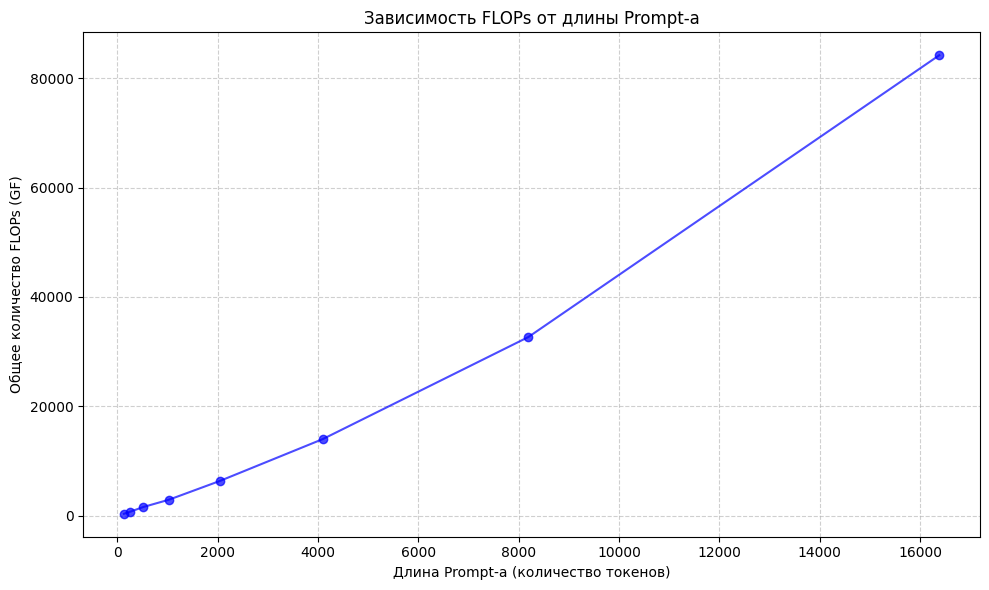

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

plot_df = pd.DataFrame({
    'Длина промпта': prompt_lengths,
    'Общее время (мс)': inference_time,
    'Общий FLOPs (GF)': flops_col
})


plt.figure(figsize=(10, 6))
plt.plot(
    plot_df['Длина промпта'],
    plot_df['Общий FLOPs (GF)'],
    marker='o',
    linestyle='-',
    color='blue',
    alpha=0.7
)
plt.title('Зависимость FLOPs от длины Prompt-а')
plt.xlabel('Длина Prompt-а (количество токенов)')
plt.ylabel('Общее количество FLOPs (GF)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('flops_vs_prompt_length_line.png')
plt.show()

Строим график зависимости времени инференса от длины промпта

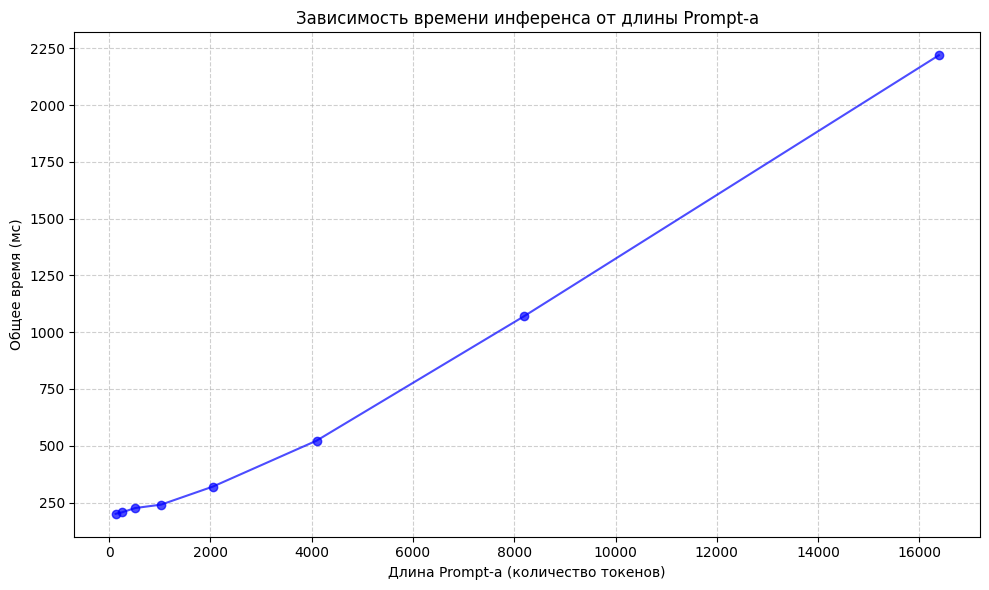

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(
    plot_df['Длина промпта'],
    plot_df['Общее время (мс)'],
    marker='o',
    linestyle='-',
    color='blue',
    alpha=0.7
)
plt.title('Зависимость времени инференса от длины Prompt-а')
plt.xlabel('Длина Prompt-а (количество токенов)')
plt.ylabel('Общее время (мс)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('time_vs_prompt_length_line.png')
plt.show()